### Loading required python Modules

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import signal
from statsmodels.robust import scale
from statsmodels.multivariate.manova import MANOVA
from statsmodels.multivariate.multivariate_ols import _MultivariateOLS as mols
from scipy.special import gammaln
import matplotlib.pyplot as plt

### Defining Paths for data and plots

In [2]:
# Base Data path
dataPath = './Data/'
# path for saving plots
plotsPath = './plots/'
# path to main dataset from MS-Wissenschaft setup (questionnaire answers)
MSW_CSV = 'msw-answers.csv'
# path to main dataset from German ministry of science and research (BMBF) setup (questionnaire answers)
BMBF_CSV = 'bmbf-answers.csv'
# path to name of headtracking data for extrakting condition of each participant for MS-Wissenschaft Setup
leftServerMswFile = 'MSW-left-files.csv'
rightServerMswFile = 'MSW-right-files.csv'
# path to name of headtracking data for extrakting condition of each participant for BMBF Setup
leftServerBmbfFile = 'bmbf-left-files.csv'
rightServerBmbfFile = 'bmbf-right-files.csv'

## MS-Wissenschaft analysis
The procedure will be exactly the same for both MS-Wissenschaft and BMBF therefore description will be only given for one dataset

### Reading Data

In [3]:
#reading data to a dataframe
data = pd.read_csv(dataPath + MSW_CSV)
#reading headtracking data filenames frrom left side computer
leftServerFiles = pd.read_csv(dataPath + leftServerMswFile , header = None)
#reading headtracking data filenames frrom right side computer
rightServerFiles = pd.read_csv(dataPath + rightServerMswFile , header = None)

### create data frame for file names

In [4]:
#convert filenames to pandas dataframe 
fileNames = pd.concat([leftServerFiles , rightServerFiles] , ignore_index = True)
#rename the columns
fileNames.columns = ['fileName']
#extract the coditions from filename
filename_df = fileNames.fileName.str.split('-' , expand = True)
#renaming the columns to uid and condition
filename_df['uid'] = filename_df[2].str.replace('.raw','')
filename_df['condition'] = filename_df[1]
#set index of filenames dataframe to uid
filename_df.set_index('uid', inplace = True)
#droping original unnamed and extra columns 
filename_df.drop(columns = [0,1,2] , inplace = True)

### Initial Cleanups

In [5]:
# converting date time to pandas date time object
data['date'] = pd.to_datetime(data['date'] , infer_datetime_format = True)
#setting index to uid from dataset
data.set_index('uid' , inplace = True)
#droping database auto increament id column
data.drop(columns = ['id'] , inplace = True)
#filtering data to those after the beginning of the experiment (removing test data)
data = data.loc[ data.date > '2019-05-14']
#removing null genders
data = data.loc[ data.Sex != 'n' ]
#merging conditions from filenames dataframe to cleanedup dataframe on uid
finalData = data.merge(filename_df, left_on='uid' , right_on='uid', how='left', suffixes=('',''))
#renaming columns for easier use
finalData.rename(columns = {'Intention to Use 1': 'Intention' , 
                  'Perceived Usefulness 4': 'Usefulness' ,
                  'Perceived Ease of Use 2': 'Ease',
                  'Trust' : 'Trust',
                  'Driving Frequency':'Driving' ,
                  'Playing Hours':'Play',
                  'VR Playing Frequency':'VR',
                  'condition':'Condition',
                  'Sex':'Gender'} , inplace = True)
finalData.Gender = finalData.Gender.map({
    'männlich' : 'Male',
    'weiblich' : 'Female',
    'intersex' : 'intersex',
    'keine Angabe':'N/A'
})
finalData = finalData.query('Age != 0 and Age != 99 ')


### Check Distribution of conditions and drop NAs

In [6]:
# check condition distribution 
print('Number of participants per condition:')
display(finalData.Condition.value_counts())
print("number of missing values per column:")
display(finalData.isna().sum())
print("proportion of missing values per column:")
display(finalData.isna().mean())

Number of participants per condition:


AVAS          2942
TaxiDriver    2895
RadioTalk     2762
Name: Condition, dtype: int64

number of missing values per column:


date            0
Intention       0
Usefulness      0
Ease            0
Trust         302
Gender          0
Age             0
Aviophobia      0
Driving         0
Play            0
VR              0
Condition       5
dtype: int64

proportion of missing values per column:


date          0.000000
Intention     0.000000
Usefulness    0.000000
Ease          0.000000
Trust         0.035100
Gender        0.000000
Age           0.000000
Aviophobia    0.000000
Driving       0.000000
Play          0.000000
VR            0.000000
Condition     0.000581
dtype: float64

### Fix NA in answers (replace with zero)

In [7]:
# fill empty trust column values with zero
finalData.Trust.fillna(finalData.Trust.median(), inplace = True)
print("number of missing values per column:")
display(finalData.isna().sum())
print("proportion of missing values per column:")
display(finalData.isna().mean())


number of missing values per column:


date          0
Intention     0
Usefulness    0
Ease          0
Trust         0
Gender        0
Age           0
Aviophobia    0
Driving       0
Play          0
VR            0
Condition     5
dtype: int64

proportion of missing values per column:


date          0.000000
Intention     0.000000
Usefulness    0.000000
Ease          0.000000
Trust         0.000000
Gender        0.000000
Age           0.000000
Aviophobia    0.000000
Driving       0.000000
Play          0.000000
VR            0.000000
Condition     0.000581
dtype: float64

### Remove remaning NAs

In [8]:
# remove raws with NA condition
finalData.dropna(inplace = True)
print("number of missing values per column:")
display(finalData.isna().sum())
print("proportion of missing values per column:")
display(finalData.isna().mean())

number of missing values per column:


date          0
Intention     0
Usefulness    0
Ease          0
Trust         0
Gender        0
Age           0
Aviophobia    0
Driving       0
Play          0
VR            0
Condition     0
dtype: int64

proportion of missing values per column:


date          0.0
Intention     0.0
Usefulness    0.0
Ease          0.0
Trust         0.0
Gender        0.0
Age           0.0
Aviophobia    0.0
Driving       0.0
Play          0.0
VR            0.0
Condition     0.0
dtype: float64

### Printing particpant data and distribution of the data in each condition

In [9]:
print('Number of participants in total:')
display(finalData.shape)
print('Number of participants per condition:')
display(finalData.Condition.value_counts())


Number of participants in total:


(8599, 12)

Number of participants per condition:


AVAS          2942
TaxiDriver    2895
RadioTalk     2762
Name: Condition, dtype: int64

## OPTBIN
OPTBIN algorithm has been used only on MSW data to define age groups in a data driven manner

### Helper functions

In [13]:
def find_bin_number(array):
    result = np.where(array == np.amax(array))
    return result[0]

### OPTBIN Implementation

In [14]:
def OPTBIN(data, maxM):
    N = data.shape[0]
    logp = np.zeros(maxM)
    for M in range(1,maxM):
        n = np.histogram(data,M)
        part_one = N * np.log(M) + gammaln(M/2) - gammaln(N+M/2)
        part_two = -1 * M * gammaln(1/2) + sum(gammaln(n[0] + 0.5))
        logp[M] = part_one + part_two
    return logp

### Preparing data for OPTBIN

In [15]:
df = (
    finalData
    .reset_index()
    .groupby(['Age'])
    .agg({'Usefulness':'mean','Intention':'mean','Ease':'mean','Trust':'mean' })
    .reset_index()    
)

### Running OPTBIN on the data

In [18]:
plog_result = list()
for TAM in ['Intention','Usefulness','Ease','Trust']:
        plog_result.append(OPTBIN(df[TAM],100))

### Visualising OPTBIN results

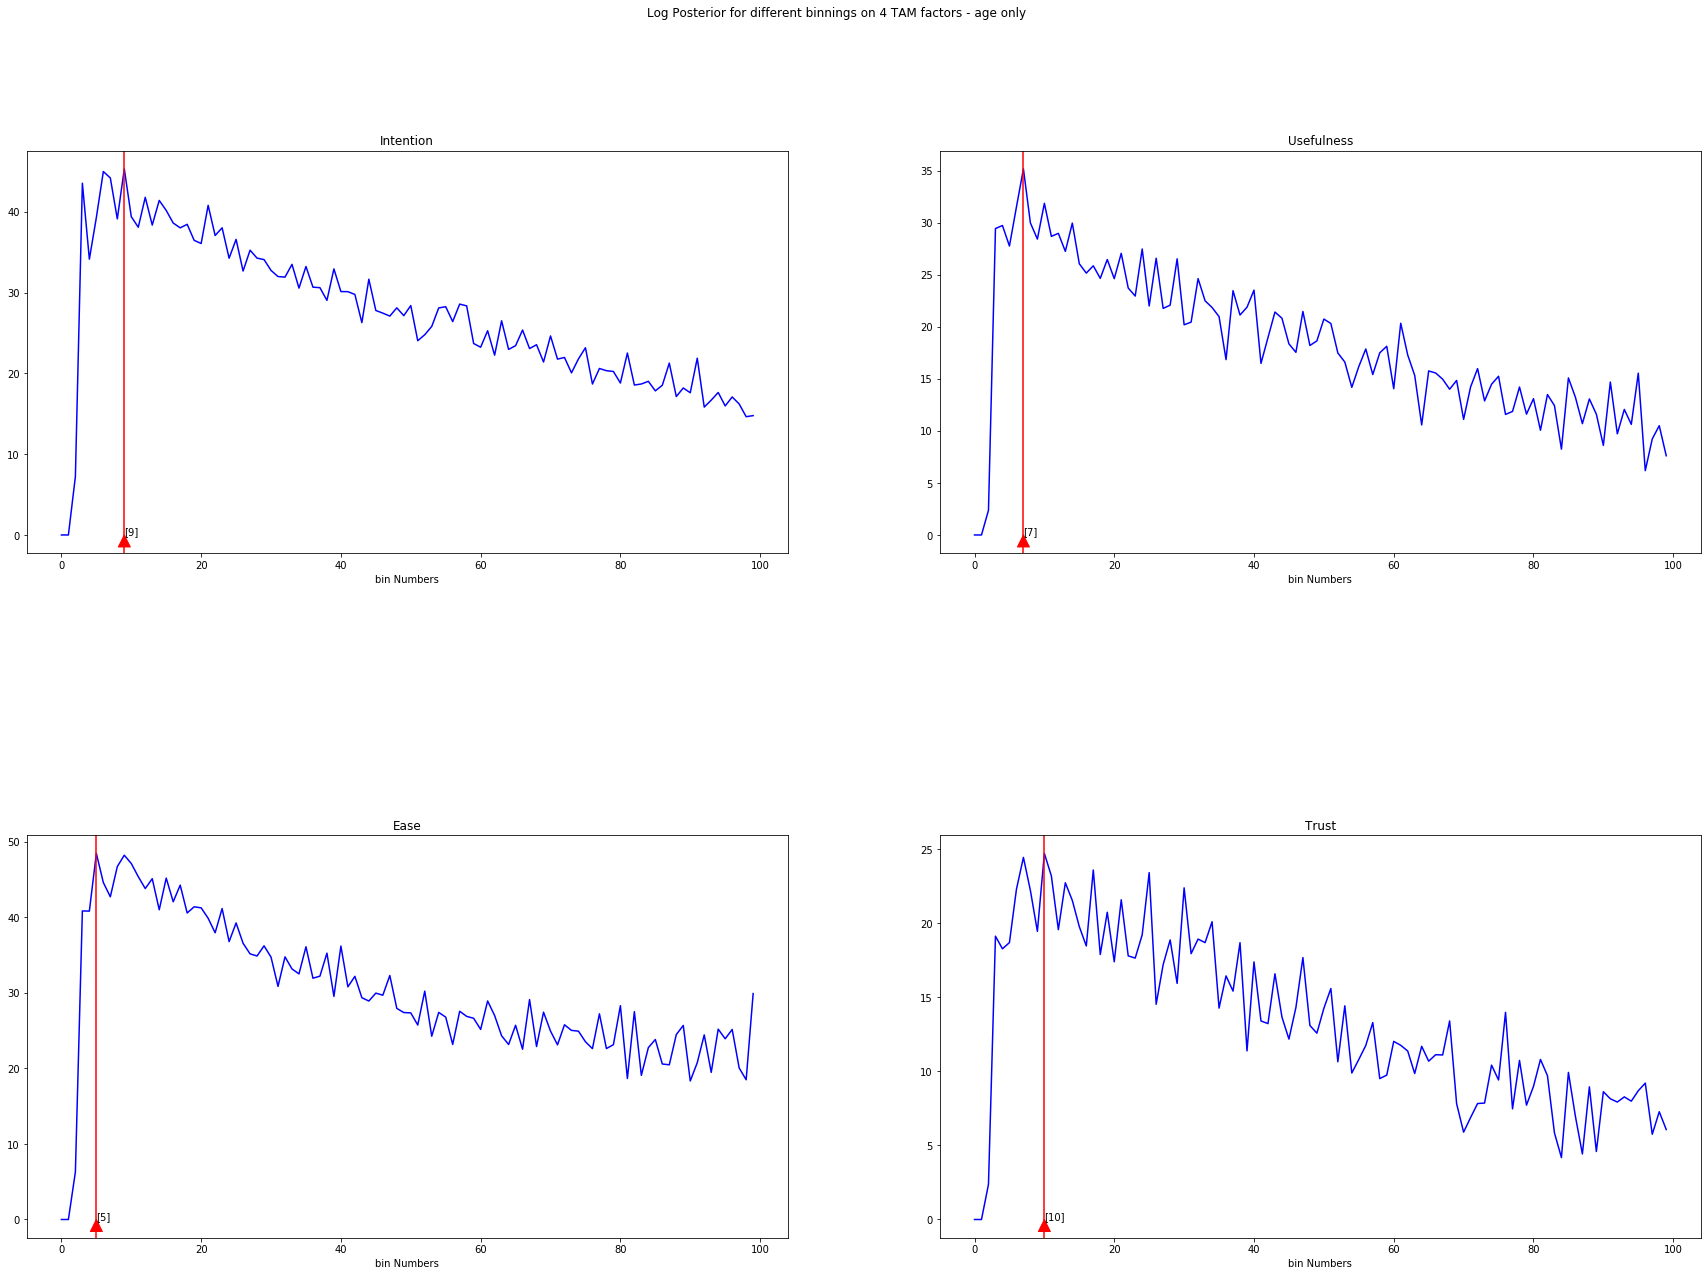

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (30,20))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Log Posterior for different binnings on 4 TAM factors - age only')
TAM = ['Intention','Usefulness','Ease','Trust']
fig.subplots_adjust(hspace=0.7)
optBinNumber = list(map(find_bin_number,plog_result))
i = 0
for ax, logp, name in zip(axes.flatten(), plog_result, TAM):
    ax.plot(logp, color='b')
    ax.set(title=name, xlabel='bin Numbers')
    ax.axvline(optBinNumber[i], color='r')
    ax.annotate(str(optBinNumber[i]), xy = (optBinNumber[i], 0), xytext = (optBinNumber[i], 0), arrowprops={'color': 'red'})
    i += 1
plt.savefig(plotsPath + 'OPTBIN/logp-age.png', dpi=300)

### Applying age groups

In [10]:
finalData['AgeGroup'] = pd.cut(finalData.Age.values, bins=[0, 20, 40, 60, 80, 100], labels=['<20','21-40','41-60','61-80','81+'])

### Filtering gender to male and female only

In [11]:
finalData = finalData.query('Gender == "Male" or Gender == "Female"')

In [12]:
spssDf = finalData.drop(columns=['Age','Aviophobia','Play','VR','Driving','date'])

In [13]:
spssDf.Gender = spssDf.Gender.map({
    'Male' : 0,
    'Female' : 1
})
spssDf.Condition = spssDf.Condition.map({
    'AVAS' : 0,
    'RadioTalk' : 1,
    'TaxiDriver': 2
})
spssDf.AgeGroup = spssDf.AgeGroup.map({
    '<20' : 0,
    '21-40' : 1,
    '41-60' : 2,
    '61-80' : 3,
    '81+' : 4
})

In [14]:
spssDf.head()

,Intention,Usefulness,Ease,Trust,Gender,Condition,AgeGroup
uid,,,,,,,
8598a83e2af441b8bcd0ae5d84beb875,100,0,100,75.0,0,1,1
42bac596059749b5b8e8e83ae61de9b4,50,34,83,75.0,1,2,2
586c107173344c59aa4f71e3573233f0,2,3,1,75.0,1,0,1
9cdd85098b0b4ad5ab2282a5ac371a5e,19,21,50,75.0,1,0,1
ff846d92c7e6471183595bd2678f29f6,0,0,50,75.0,1,0,1


In [15]:
spssDf.to_csv (dataPath + 'MSW-Spss.csv', index = False, header=True)

### Correlation matrix of dependent variables

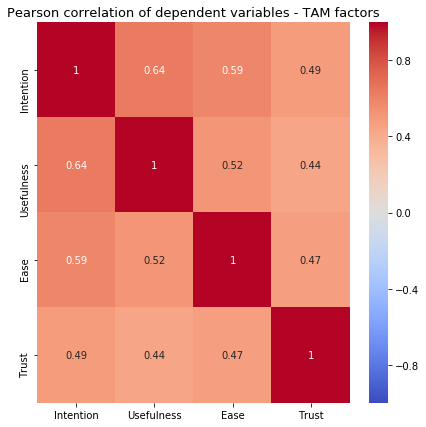

In [20]:
tempdf = finalData.drop(columns=['Age','Aviophobia','Play','VR','Driving','date'])
_ , ax = plt.subplots(figsize=(7,7))
sns.heatmap(tempdf.corr(),vmin=-1,vmax=1,ax=ax, cmap='coolwarm',annot=True)
plt.title('Pearson correlation of dependent variables - TAM factors', fontsize=13)
plt.savefig(plotsPath +'Correlations/TAM_correlation.png', quality = 1200)

### Descriptive statist

In [22]:
tempdf.describe()

,Intention,Usefulness,Ease,Trust
count,8599.000000,8599.000000,8599.000000,8599.000000
mean,60.822305,63.580533,64.447029,66.560995
std,34.515630,32.348532,31.435116,31.504604
min,0.000000,0.000000,0.000000,0.000000
25%,32.000000,50.000000,50.000000,49.000000
50%,66.000000,70.000000,70.000000,75.000000
75%,100.000000,97.000000,99.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000


### Running MANOVA

In [25]:
maov = MANOVA.from_formula('''Intention + Usefulness + Ease + Trust
                            ~ C(AgeGroup) + C(Gender) + C(Condition) 
                            + C(AgeGroup):C(Gender)
                            ''', data=finalData)

### MANOVA summary

In [26]:
print(maov.mv_test().summary())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.4819 4.0000 7835.0000 2106.2050 0.0000
         Pillai's trace 0.5181 4.0000 7835.0000 2106.2050 0.0000
 Hotelling-Lawley trace 1.0753 4.0000 7835.0000 2106.2050 0.0000
    Roy's greatest root 1.0753 4.0000 7835.0000 2106.2050 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
      C(AgeGroup)       Value   Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9693 16.0000 23936.9580 15.3224 0.0000
         Pillai's trace 0.0307 16.0000 31352.

### LDA as post-hoc test for MANOVA

### Visualising gender effect

In [27]:
df = (
    finalData
    .reset_index()
    .groupby(['Condition', 'uid','AgeGroup', 'Gender'])
    .agg({'Usefulness':'mean','Intention':'mean','Ease':'mean','Trust':'mean' })
    .reset_index()    
)
df = pd.melt(df, id_vars=['Condition','AgeGroup', 'Gender'], value_vars=['Usefulness','Intention','Ease','Trust'], 
             var_name='TAM', value_name='Score')

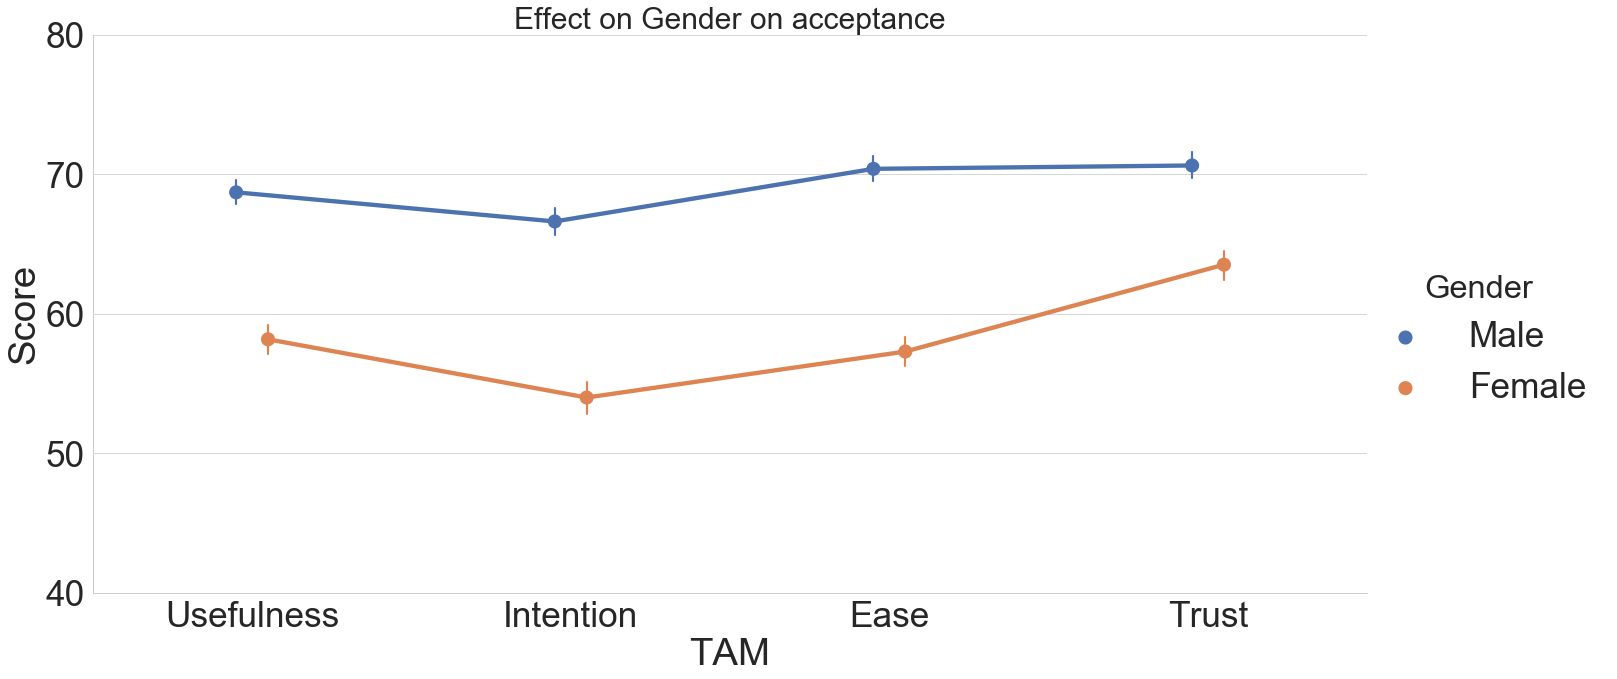

In [68]:
sns.set(context = "paper", style="whitegrid", font_scale=4, rc={'figure.figsize':(10,20)})
g = sns.catplot(data=df,x='TAM',y='Score',                   
                   hue='Gender',
                   kind = 'point',
                   dodge=0.1,
                   ci=95,
                   height=10,
                   aspect=2,
                   scale =2)
g = (
    g
    .set(yticks=np.arange(0,100,10), ylim=(40,80))
)
mean = df.loc[df['Gender'] == 'Male'].Score.mean()
#plt.axhline(mean, color='k', ls='--' ,lw=3)
#plt.annotate(str('{:.3f}').format(mean), xy = (0, mean - 10),fontsize='small')
plt.title('Effect on Gender on acceptance', fontsize=30)
plt.savefig(plotsPath +'Effects/TAM_by_gender.png', quality = 90)

### visualising effect of AgeGroups

In [57]:
df = (
    finalData
    .reset_index()
    .groupby(['Condition', 'uid','AgeGroup', 'Gender'])
    .agg({'Usefulness':'mean','Intention':'mean','Ease':'mean','Trust':'mean' })
    .reset_index()    
)
df = pd.melt(df, id_vars=['Condition','AgeGroup', 'Gender'], value_vars=['Usefulness','Intention','Ease','Trust'], 
             var_name='TAM', value_name='Score')


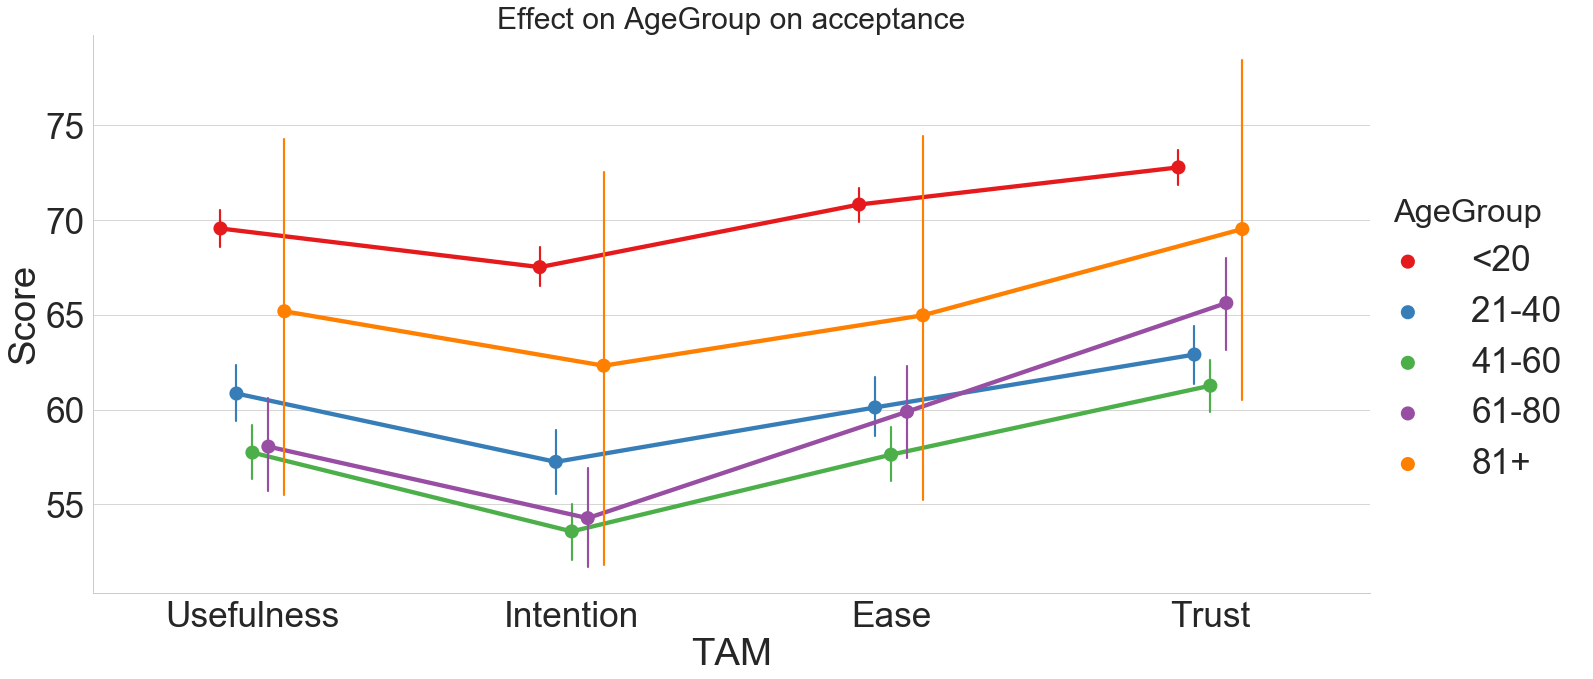

In [67]:
sns.set(context = "paper", style="whitegrid", palette="Set1", font_scale=4, rc={'figure.figsize':(10,20)})
g = sns.catplot(data=df,x='TAM',y='Score',
                   hue='AgeGroup',
                   
                   kind='point',
                   dodge=0.2,
                   ci=95,
                   height=10,
                   aspect=2,
                   scale = 2
                   )
mean = df.loc[df['AgeGroup'] == '<20'].Score.mean()
plt.title('Effect on AgeGroup on acceptance', fontsize=30)
plt.savefig(plotsPath +'Effects/TAM_by_age_group.png', quality = 90)

### visualising the effect of condition

In [52]:
df = (
    finalData
    .reset_index()
    .groupby(['Condition', 'uid','AgeGroup', 'Gender'])
    .agg({'Usefulness':'mean','Intention':'mean','Ease':'mean','Trust':'mean' })
    .reset_index()    
)
df = pd.melt(df, id_vars=['Condition'], value_vars=['Usefulness','Intention','Ease','Trust'], 
             var_name='TAM', value_name='Score')


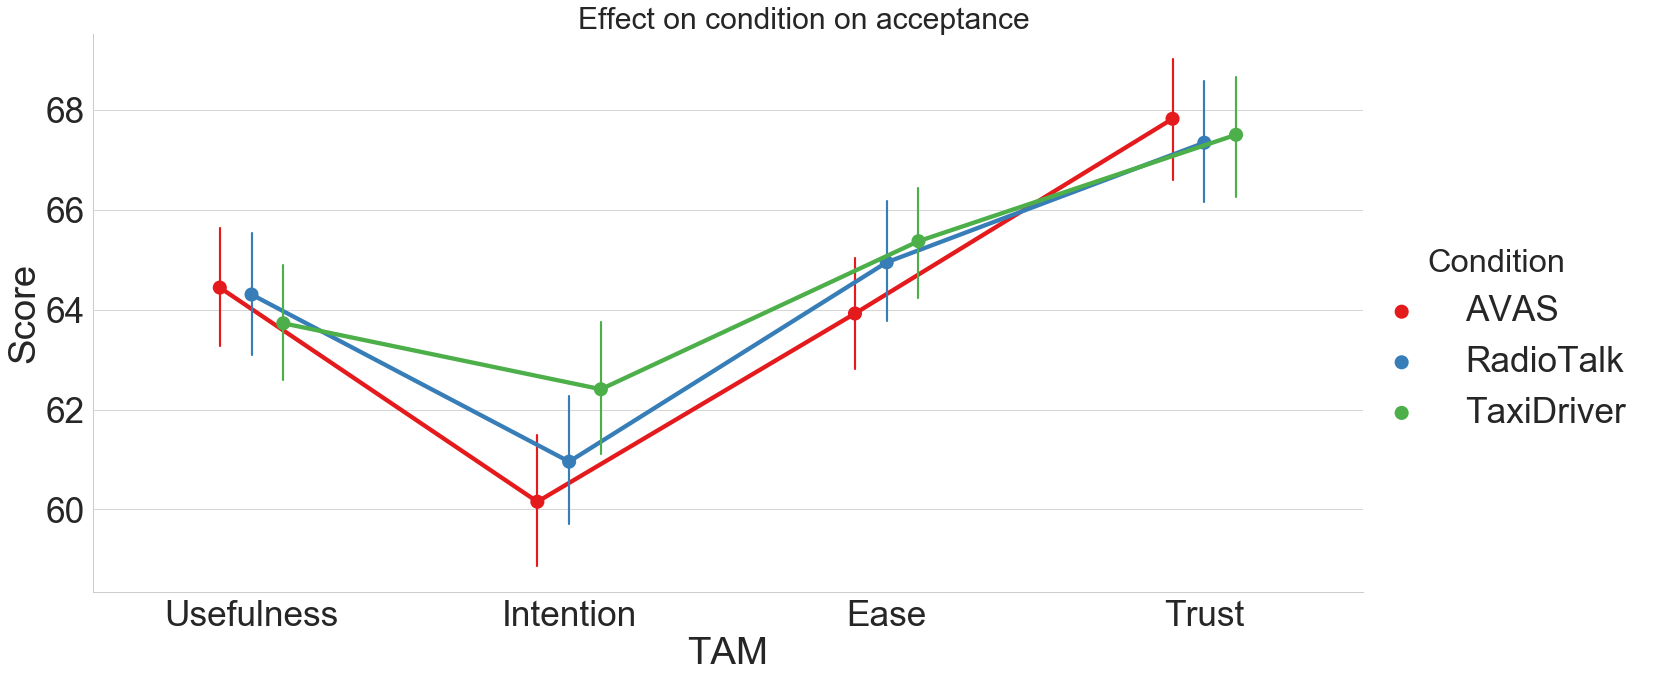

In [66]:
sns.set(context = "paper", style="whitegrid", palette="Set1", font_scale=4, rc={'figure.figsize':(10,20)})
g = sns.catplot(data=df,x='TAM',y='Score',
                   hue='Condition',
                   kind='point',
                   dodge=0.2,
                   ci=95,
                   height=10,
                   aspect=2,
                   scale = 2
                   )
plt.suptitle('Effect on condition on acceptance', fontsize=30)
plt.savefig(plotsPath +'Effects/TAM_by_condition_1.png', quality = 90)

### Visualising AgeGroup and Gender interaction

In [61]:
df = (
    finalData
    .reset_index()
    .groupby(['Condition', 'uid','AgeGroup', 'Gender'])
    .agg({'Usefulness':'mean','Intention':'mean','Ease':'mean','Trust':'mean' })
    .reset_index()    
)
df = pd.melt(df, id_vars=['Condition','AgeGroup', 'Gender'], value_vars=['Usefulness','Intention','Ease','Trust'], 
             var_name='TAM', value_name='Score')


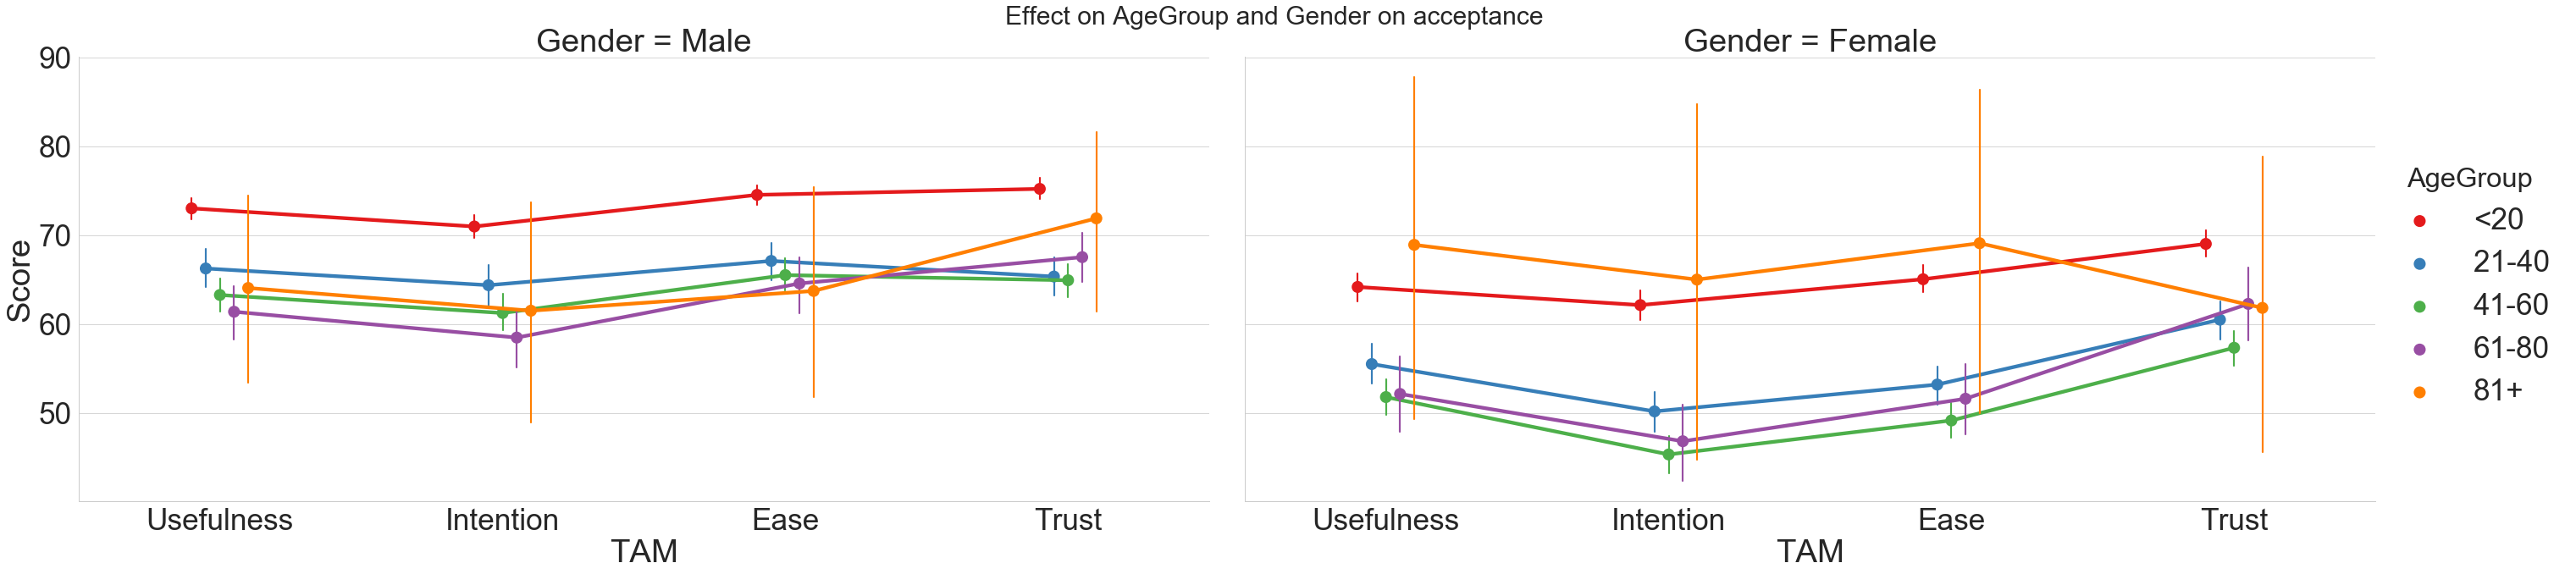

In [65]:
sns.set(context = "paper", style="whitegrid", palette="Set1", font_scale=4, rc={'figure.figsize':(10,20)})
g = sns.catplot(data=df,x='TAM',y='Score',
                   hue='AgeGroup',
                   col='Gender',
                   kind='point',
                   dodge=0.2,
                   ci=95,
                   height=10,
                   aspect=2,
                   scale = 2
                   )
mean = df.loc[df['AgeGroup'] == '<20'].Score.mean()
plt.suptitle('Effect on AgeGroup and Gender on acceptance', fontsize=30)
plt.savefig(plotsPath +'Effects/TAM_by_age_group_and_gender.png', quality = 90)